In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


Epoch   0 | G Loss: 0.7212 | D Loss: 1.3939 | Recon MAE: 0.6498
Epoch  50 | G Loss: 0.1076 | D Loss: 1.7927 | Recon MAE: 0.0911
Epoch 100 | G Loss: 0.0757 | D Loss: 1.8991 | Recon MAE: 0.0592
Epoch 150 | G Loss: 0.0739 | D Loss: 1.8497 | Recon MAE: 0.0533
Epoch 200 | G Loss: 0.0643 | D Loss: 1.8745 | Recon MAE: 0.0439
Epoch 250 | G Loss: 0.0536 | D Loss: 2.3006 | Recon MAE: 0.0399
Epoch 299 | G Loss: 0.0634 | D Loss: 1.8084 | Recon MAE: 0.0380
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


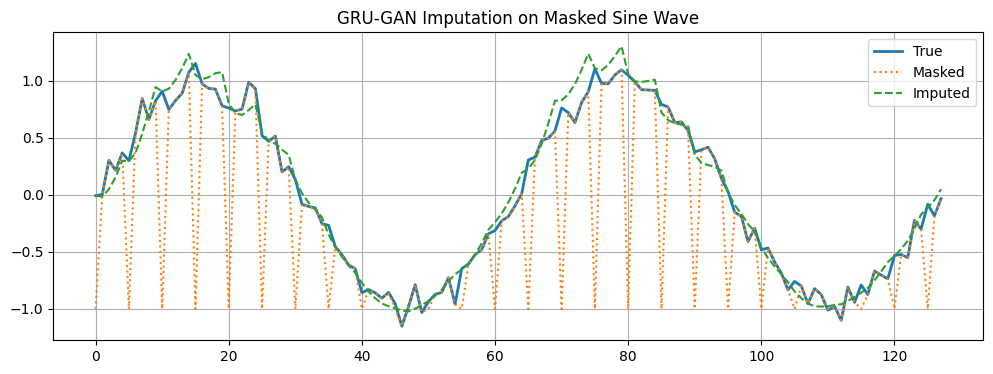

In [12]:
# ======= Imports =======
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ======= Generate Sine Wave with 20% Missing =======
seq_len = 128
x = np.linspace(0, 4 * np.pi, seq_len)
original = np.sin(x) + 0.1 * np.random.randn(seq_len)

masked = original.copy()
masked[::5] = -1.0
mask = np.ones_like(original)
mask[::5] = 0

X_input = masked.reshape((1, seq_len, 1)).astype(np.float32)
Y_true = original.reshape((1, seq_len, 1)).astype(np.float32)
mask = mask.reshape((1, seq_len, 1)).astype(np.float32)

# ======= Models =======
def build_generator(seq_len=128):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len=128):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

generator = build_generator()
discriminator = build_discriminator()

# ======= Training Setup =======
epochs = 300
lr = 0.001
g_opt = Adam(learning_rate=lr)
d_opt = Adam(learning_rate=lr)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ======= Plot Result =======
imputed_result = generator.predict(X_input)[0, :, 0]

plt.figure(figsize=(12, 4))
plt.plot(original, label="True", linewidth=2)
plt.plot(masked, label="Masked", linestyle="dotted")
plt.plot(imputed_result, label="Imputed", linestyle="--")
plt.title("GRU-GAN Imputation on Masked Sine Wave")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
df = pd.read_excel('metered_data.xlsx')

In [15]:
df.columns

Index(['datetime_beginning_ept', 'mw', 'year', 'month', 'day', 'hour'], dtype='object')

In [16]:
pjm_2024 = df[df['year'] == 2024].copy().reset_index(drop=True)
pjm_2024 = pjm_2024.iloc[:100]

# Extract the 'mw' values as a NumPy array
series = pjm_2024['mw'].values.astype(np.float32)

# Normalize (optional but helps training)
mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# Function to create overlapping masked sequences
def prepare_pjm_sequences(series, seq_len=32, step=8, missing_rate=0.2, placeholder=-1.0):
    sequences, masked_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, size=int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        sequences.append(seq)
        masked_seqs.append(masked)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(sequences)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

# Create overlapping sequences
X_input, Y_true, mask = prepare_pjm_sequences(series_norm, seq_len=32, step=8)

# Sanity check
print("Shape of input:", X_input.shape)
print("Example masked sequence:", X_input[0].flatten())

Shape of input: (9, 32, 1)
Example masked sequence: [-1.         -1.3608261  -1.4758302  -1.         -1.362427   -1.1194233
 -0.84764266 -0.66690636 -0.6161491  -0.6826831  -0.7455613  -0.7524867
 -0.7695219  -0.76666176 -1.         -0.5067295  -0.03579252  0.5070022
  0.5645128   0.45319468  0.25726914 -1.         -0.5140798  -1.
 -1.         -1.3332347  -1.3548298  -1.2266588  -0.8606255  -0.16787215
  0.7679667   1.3874413 ]


Epoch   0 | G Loss: 0.8678 | D Loss: 1.3837 | Recon MAE: 0.7993
Epoch  50 | G Loss: 0.3224 | D Loss: 2.4570 | Recon MAE: 0.3112
Epoch 100 | G Loss: 0.2951 | D Loss: 1.8643 | Recon MAE: 0.2703
Epoch 150 | G Loss: 0.2656 | D Loss: 2.1231 | Recon MAE: 0.2485
Epoch 200 | G Loss: 0.2360 | D Loss: 2.1881 | Recon MAE: 0.2199
Epoch 250 | G Loss: 0.2167 | D Loss: 2.2303 | Recon MAE: 0.2027
Epoch 299 | G Loss: 0.2137 | D Loss: 1.7834 | Recon MAE: 0.1856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


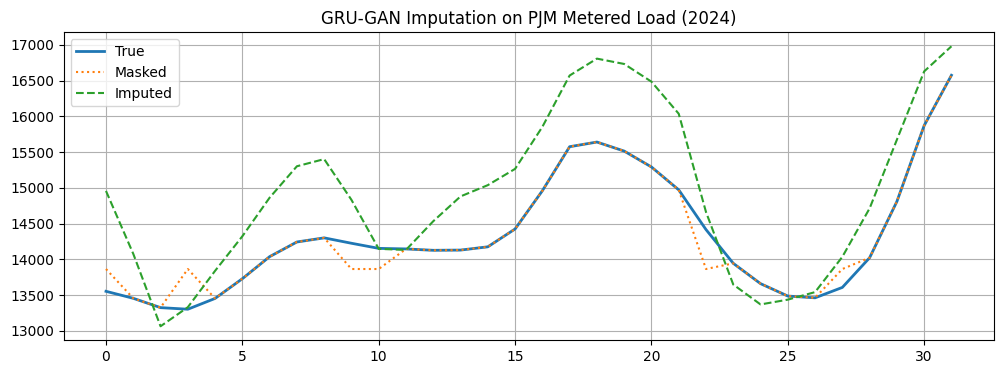

In [17]:
# ================== Imports ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ================== Load & Prepare PJM Data ==================
pjm_2024 = df[df['year'] == 2024].copy().reset_index(drop=True).iloc[:100]
series = pjm_2024['mw'].values.astype(np.float32)

# Normalize
mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# Function to create overlapping sequences with masks
def prepare_pjm_sequences(series, seq_len=32, step=8, missing_rate=0.2, placeholder=-1.0):
    sequences, masked_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, size=int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        sequences.append(seq)
        masked_seqs.append(masked)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(sequences)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

# Generate training data
X_input, Y_true, mask = prepare_pjm_sequences(series_norm, seq_len=32, step=8)
seq_len = X_input.shape[1]

# ================== Build GRU Generator & Discriminator ==================
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

generator = build_generator(seq_len)
discriminator = build_discriminator(seq_len)

# ================== Train GAN ==================
epochs = 300
lr = 0.001
g_opt = Adam(learning_rate=lr)
d_opt = Adam(learning_rate=lr)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ================== Plot Imputation on Sample ==================
imputed_all = generator.predict(X_input)[:, :, 0]

i = 0  # index of the sample to visualize
plt.figure(figsize=(12, 4))
plt.plot(Y_true[i,:,0] * std + mean, label="True", linewidth=2)
plt.plot(X_input[i,:,0] * std + mean, label="Masked", linestyle="dotted")
plt.plot(imputed_all[i] * std + mean, label="Imputed", linestyle="--")
plt.title("GRU-GAN Imputation on PJM Metered Load (2024)")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
reconstructed = np.full_like(series_norm, np.nan)
counts = np.zeros_like(series_norm)

for idx, start in enumerate(range(0, len(series_norm) - seq_len, 8)):
    imputed_seq = imputed_all[idx]
    mask_seq = mask[idx, :, 0]
    original_seq = X_input[idx, :, 0]

    # Insert only where masked
    for j in range(seq_len):
        if mask_seq[j] == 0:  # it was missing
            reconstructed[start + j] += imputed_seq[j]
            counts[start + j] += 1
        else:
            reconstructed[start + j] += original_seq[j]
            counts[start + j] += 1

# Average overlapping predictions
reconstructed = reconstructed / np.maximum(counts, 1)

# De-normalize to get back to MW
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


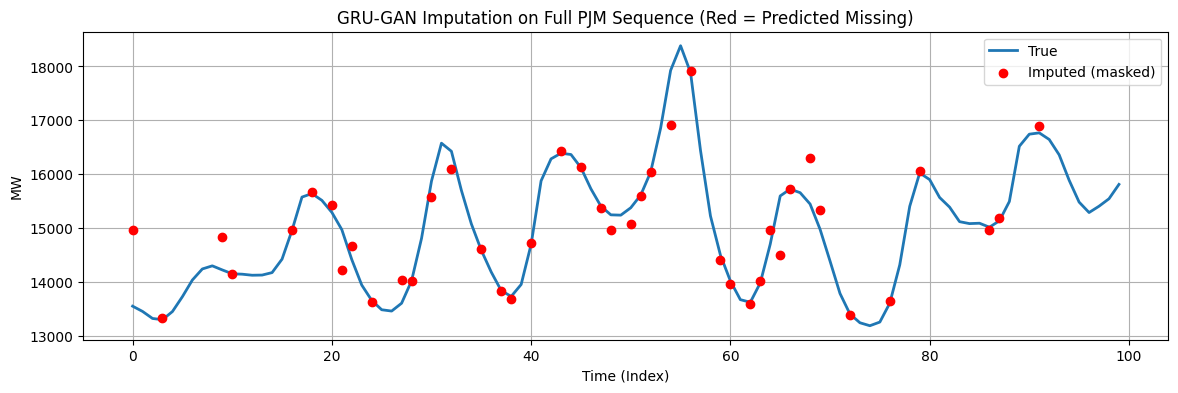

In [22]:
# Initialize empty series
reconstructed = np.full_like(series_norm, np.nan)
mask_accum = np.ones_like(series_norm)

for idx, start in enumerate(range(0, len(series_norm) - seq_len, 8)):
    imputed_seq = generator.predict(X_input)[idx, :, 0]
    mask_seq = mask[idx, :, 0]

    for j in range(seq_len):
        if mask_seq[j] == 0:
            pos = start + j
            if pos < len(reconstructed):  # safety
                reconstructed[pos] = imputed_seq[j]
                mask_accum[pos] = 0  # 0 means this was masked

# De-normalize
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean

# Get missing (imputed) positions
missing_idx = np.where(mask_accum == 0)[0]
imputed_values = reconstructed[missing_idx]

# Plot full original + imputed red dots
plt.figure(figsize=(14, 4))
plt.plot(true_series, label="True", linewidth=2)
plt.scatter(missing_idx, imputed_values, color="red", label="Imputed (masked)", zorder=5)
plt.title("GRU-GAN Imputation on Full PJM Sequence (Red = Predicted Missing)")
plt.xlabel("Time (Index)")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


Epoch   0 | G Loss: 0.8940 | D Loss: 1.3961 | Recon MAE: 0.8186
Epoch  50 | G Loss: 0.3363 | D Loss: 2.1619 | Recon MAE: 0.3206
Epoch 100 | G Loss: 0.2635 | D Loss: 2.3504 | Recon MAE: 0.2476
Epoch 150 | G Loss: 0.1758 | D Loss: 1.6308 | Recon MAE: 0.1493
Epoch 200 | G Loss: 0.1003 | D Loss: 2.2801 | Recon MAE: 0.0867
Epoch 250 | G Loss: 0.0940 | D Loss: 2.3244 | Recon MAE: 0.0845
Epoch 299 | G Loss: 0.0772 | D Loss: 2.0423 | Recon MAE: 0.0644
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


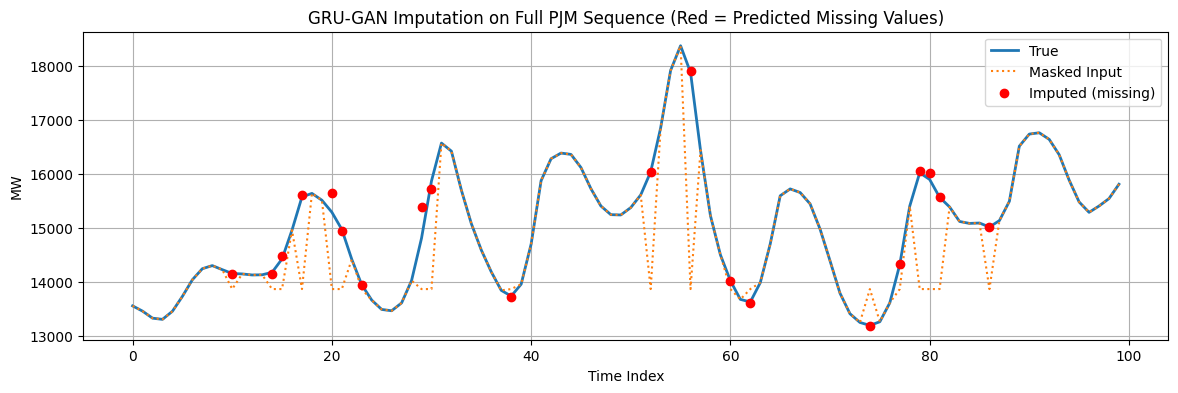

In [24]:
# ================== Imports ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ================== Load PJM Data ==================
pjm_2024 = df[df['year'] == 2024].copy().reset_index(drop=True).iloc[:100]
series = pjm_2024['mw'].values.astype(np.float32)

# Normalize
mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# ================== Create Full Masked Sequence ==================
seq_len = len(series_norm)
masked = series_norm.copy()
mask = np.ones(seq_len)

# Randomly mask 20% of points
missing_idx = np.random.choice(seq_len, size=int(0.2 * seq_len), replace=False)
masked[missing_idx] = -1.0
mask[missing_idx] = 0

X_input = masked.reshape((1, seq_len, 1)).astype(np.float32)
Y_true = series_norm.reshape((1, seq_len, 1)).astype(np.float32)
mask = mask.reshape((1, seq_len, 1)).astype(np.float32)

# ================== Build Models ==================
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

generator = build_generator(seq_len)
discriminator = build_discriminator(seq_len)

# ================== Training Loop ==================
epochs = 300
lr = 0.001
g_opt = Adam(learning_rate=lr)
d_opt = Adam(learning_rate=lr)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ================== Plot Full Sequence with Imputed Dots ==================
imputed = generator.predict(X_input)[0, :, 0]
true_series = Y_true[0, :, 0] * std + mean
masked_series = X_input[0, :, 0] * std + mean
imputed_values = imputed[missing_idx] * std + mean

plt.figure(figsize=(14, 4))
plt.plot(true_series, label="True", linewidth=2)
plt.scatter(missing_idx, imputed_values, color='red', label="Imputed (missing)", zorder=5)
plt.title("GRU-GAN Imputation on Full PJM Sequence (Red = Predicted Missing Values)")
plt.xlabel("Time Index")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


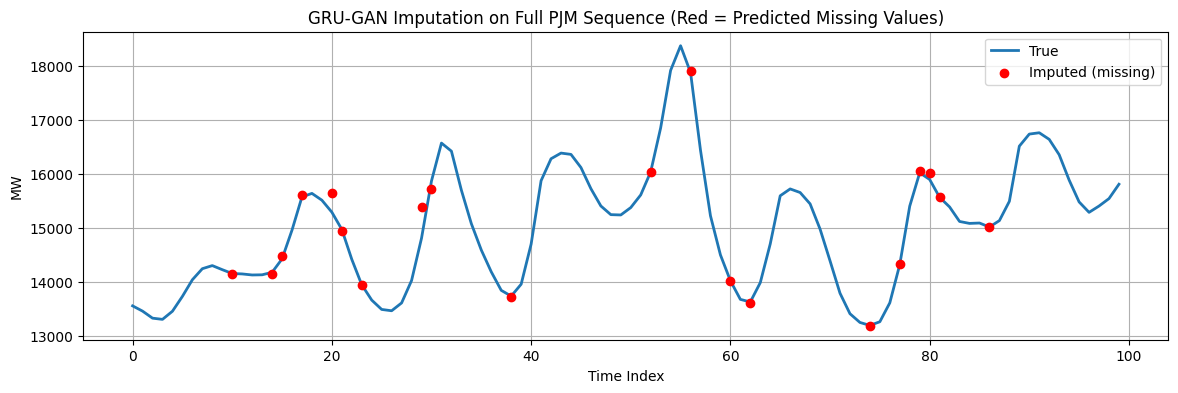

In [25]:
# ================== Plot Full Sequence with Imputed Dots ==================
imputed = generator.predict(X_input)[0, :, 0]
true_series = Y_true[0, :, 0] * std + mean
masked_series = X_input[0, :, 0] * std + mean
imputed_values = imputed[missing_idx] * std + mean

plt.figure(figsize=(14, 4))
plt.plot(true_series, label="True", linewidth=2)
plt.scatter(missing_idx, imputed_values, color='red', label="Imputed (missing)", zorder=5)
plt.title("GRU-GAN Imputation on Full PJM Sequence (Red = Predicted Missing Values)")
plt.xlabel("Time Index")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


Epoch   0 | G Loss: 0.9005 | D Loss: 1.3911 | Recon MAE: 0.8317
Epoch  10 | G Loss: 0.5790 | D Loss: 1.4953 | Recon MAE: 0.5251
Epoch  20 | G Loss: 0.4616 | D Loss: 1.8308 | Recon MAE: 0.4312
Epoch  30 | G Loss: 0.3906 | D Loss: 2.6410 | Recon MAE: 0.3818
Epoch  40 | G Loss: 0.3600 | D Loss: 2.5182 | Recon MAE: 0.3503
Epoch  50 | G Loss: 0.3443 | D Loss: 2.3305 | Recon MAE: 0.3325
Epoch  60 | G Loss: 0.3294 | D Loss: 2.2952 | Recon MAE: 0.3172
Epoch  70 | G Loss: 0.3205 | D Loss: 2.1152 | Recon MAE: 0.3055
Epoch  80 | G Loss: 0.3138 | D Loss: 1.9710 | Recon MAE: 0.2953
Epoch  90 | G Loss: 0.3068 | D Loss: 1.8788 | Recon MAE: 0.2856
Epoch  99 | G Loss: 0.3001 | D Loss: 1.8407 | Recon MAE: 0.2772
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step


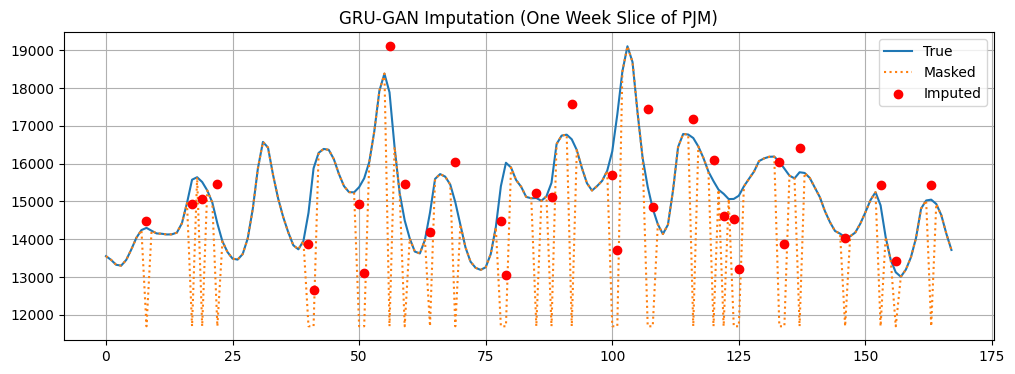

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ================== Load & Normalize ==================
pjm = df[df['year'] == 2024]
series = pjm['mw'].values.astype(np.float32)

mean = np.mean(series)
std = np.std(series)
series_norm = (series - mean) / std

# ================== Slice Into Chunks ==================
def slice_sequences(series, seq_len=168, step=24, missing_rate=0.2, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(true_seqs)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

X_input, Y_true, mask = slice_sequences(series_norm, seq_len=168, step=24)

# ================== Build GRU-GAN ==================
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

seq_len = X_input.shape[1]
generator = build_generator(seq_len)
discriminator = build_discriminator(seq_len)

# ================== Train Loop ==================
epochs = 100
g_opt = Adam(0.001)
d_opt = Adam(0.001)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ================== Plot a Sample ==================
i = 0  # example index
imputed = generator.predict(X_input)[i, :, 0]
true_seq = Y_true[i, :, 0] * std + mean
masked_seq = X_input[i, :, 0] * std + mean
mask_seq = mask[i, :, 0]
imputed_values = imputed[mask_seq == 0] * std + mean
missing_idx = np.where(mask_seq == 0)[0]

plt.figure(figsize=(12, 4))
plt.plot(true_seq, label="True")
plt.plot(masked_seq, label="Masked", linestyle="dotted")
plt.scatter(missing_idx, imputed_values, color="red", label="Imputed", zorder=5)
plt.title("GRU-GAN Imputation (One Week Slice of PJM)")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# === Predict on all sequences ===
imputed_all = generator.predict(X_input)[:, :, 0]  # shape: (n_slices, 168)

reconstructed = np.zeros_like(series_norm)
count = np.zeros_like(series_norm)

seq_len = 168
step = 24
n_slices = imputed_all.shape[0]

for i in range(n_slices):
    start = i * step
    end = start + seq_len
    if end > len(series_norm): break
    reconstructed[start:end] += imputed_all[i]
    count[start:end] += 1

# Avoid division by 0
reconstructed = np.divide(reconstructed, count, out=np.zeros_like(reconstructed), where=count != 0)

# === De-normalize ===
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


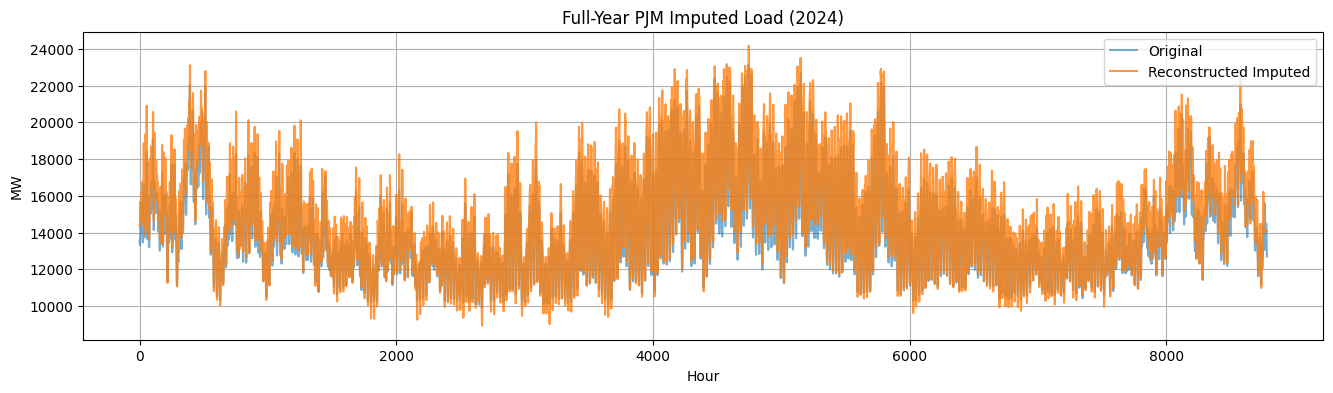

In [35]:
plt.figure(figsize=(16, 4))
plt.plot(true_series, label="Original", alpha=0.6)
plt.plot(reconstructed, label="Reconstructed Imputed", alpha=0.8)
plt.title("Full-Year PJM Imputed Load (2024)")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


Epoch   0 | G Loss: 0.9354 | D Loss: 1.3906 | Recon MAE: 0.8657
Epoch  10 | G Loss: 0.5877 | D Loss: 1.4499 | Recon MAE: 0.5310
Epoch  20 | G Loss: 0.4663 | D Loss: 1.6722 | Recon MAE: 0.4273
Epoch  30 | G Loss: 0.3881 | D Loss: 2.7060 | Recon MAE: 0.3798
Epoch  40 | G Loss: 0.3566 | D Loss: 2.4736 | Recon MAE: 0.3466
Epoch  50 | G Loss: 0.3382 | D Loss: 2.4023 | Recon MAE: 0.3276
Epoch  60 | G Loss: 0.3240 | D Loss: 2.2970 | Recon MAE: 0.3117
Epoch  70 | G Loss: 0.3125 | D Loss: 2.2753 | Recon MAE: 0.2999
Epoch  80 | G Loss: 0.3037 | D Loss: 2.1656 | Recon MAE: 0.2892
Epoch  90 | G Loss: 0.2948 | D Loss: 2.1186 | Recon MAE: 0.2795
Epoch  99 | G Loss: 0.2858 | D Loss: 2.1790 | Recon MAE: 0.2712
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step


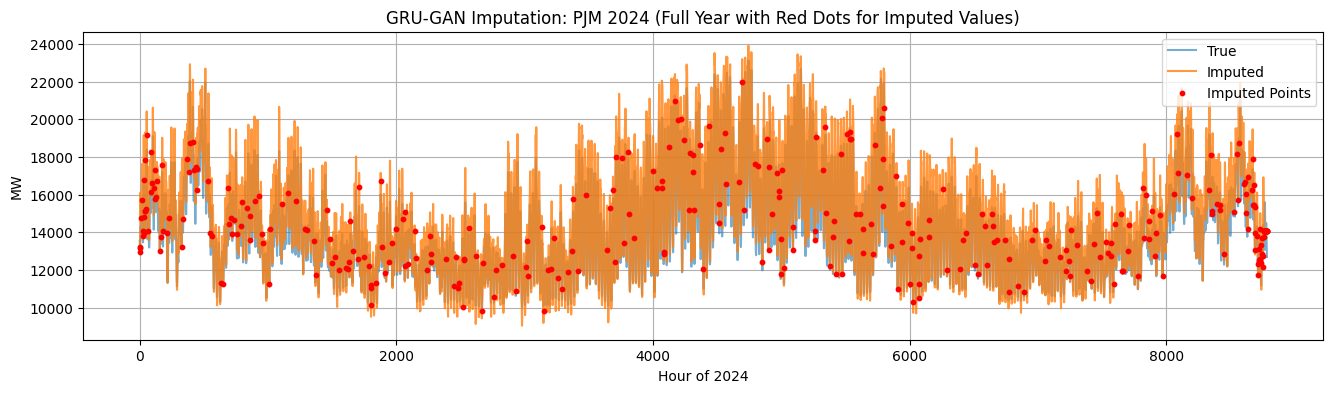

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ================== Load & Normalize ==================
pjm = df[df['year'] == 2024].reset_index(drop=True)
series = pjm['mw'].values.astype(np.float32)

mean = np.mean(series)
std = np.std(series)
series_norm = (series - mean) / std

# ================== Slice Into Chunks ==================
def slice_sequences(series, seq_len=168, step=24, missing_rate=0.2, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(true_seqs)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

X_input, Y_true, mask = slice_sequences(series_norm, seq_len=168, step=24)

# ================== Build GRU-GAN ==================
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

seq_len = X_input.shape[1]
generator = build_generator(seq_len)
discriminator = build_discriminator(seq_len)

# ================== Train Loop ==================
epochs = 100
g_opt = Adam(0.001)
d_opt = Adam(0.001)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ================== Reconstruct Full Sequence ==================
imputed_chunks = generator.predict(X_input)[:, :, 0]

reconstructed = np.zeros_like(series_norm)
count = np.zeros_like(series_norm)

for i in range(imputed_chunks.shape[0]):
    start = i * 24
    end = start + 168
    if end > len(series_norm):
        break
    reconstructed[start:end] += imputed_chunks[i]
    count[start:end] += 1

reconstructed = np.divide(reconstructed, count, out=np.zeros_like(reconstructed), where=count != 0)
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean

# ================== Reconstruct Full Mask ==================
def reconstruct_mask(mask_chunks, seq_len=168, step=24, total_len=None):
    if total_len is None:
        total_len = (mask_chunks.shape[0] - 1) * step + seq_len
    full_mask = np.zeros(total_len)
    count = np.zeros(total_len)

    for i, m in enumerate(mask_chunks):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full_mask[start:end] += m.squeeze()
        count[start:end] += 1

    avg_mask = full_mask / np.maximum(count, 1)
    mask_all = (avg_mask > 0.5).astype(int)
    return mask_all

mask_all = reconstruct_mask(mask, seq_len=168, step=24, total_len=len(series_norm))

# ================== Plot Full Series with Red Dots ==================
missing_idx = np.where(mask_all == 0)[0]
imputed_values = reconstructed[missing_idx]

plt.figure(figsize=(16, 4))
plt.plot(true_series, label="True", alpha=0.6)
plt.plot(reconstructed, label="Imputed", alpha=0.8)
plt.scatter(missing_idx, imputed_values, color="red", label="Imputed Points", s=10, zorder=5)
plt.title("GRU-GAN Imputation: PJM 2024 (Full Year with Red Dots for Imputed Values)")
plt.xlabel("Hour of 2024")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


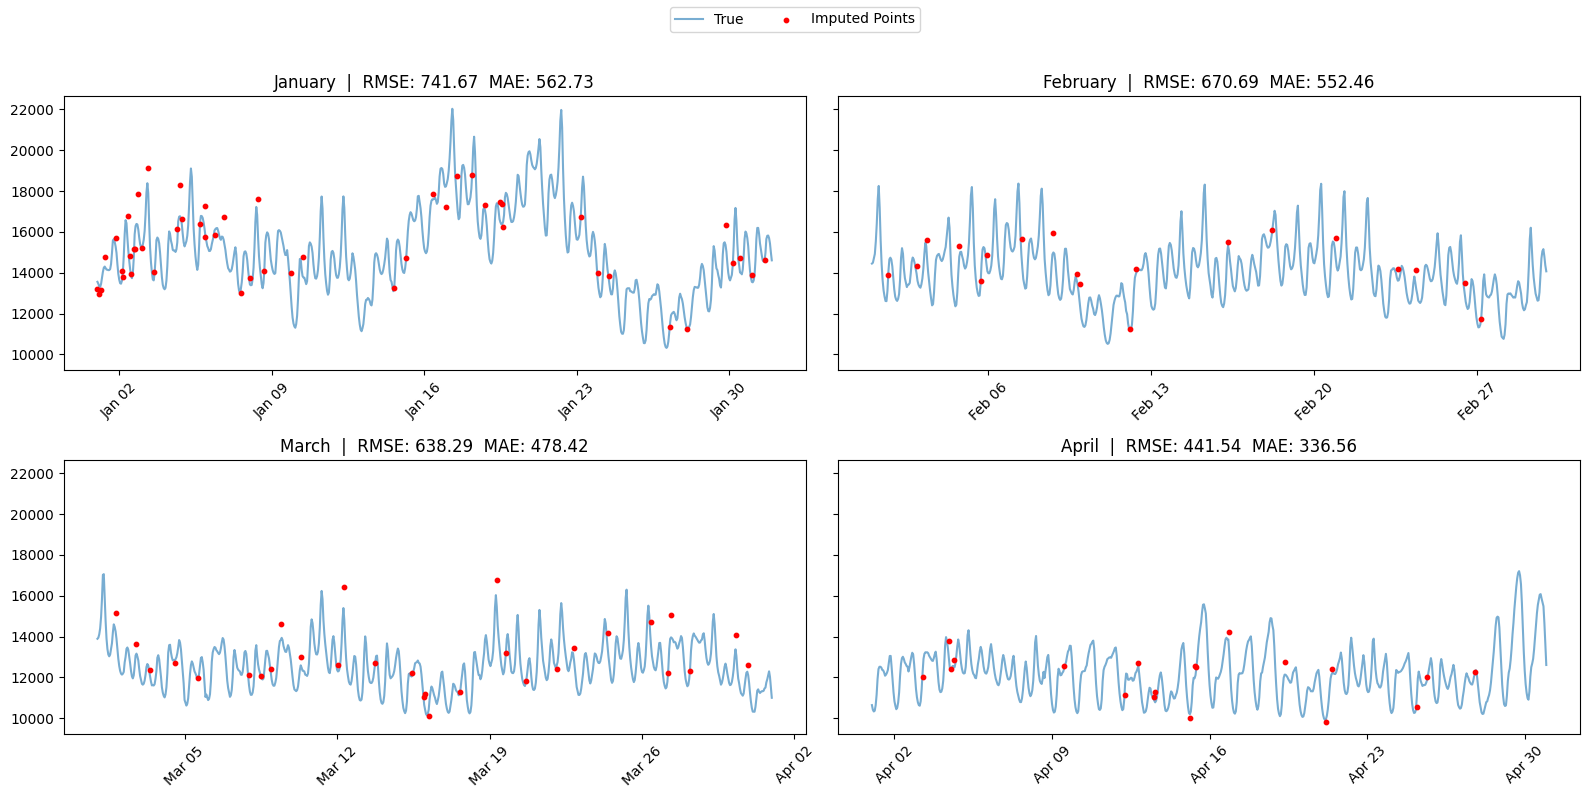

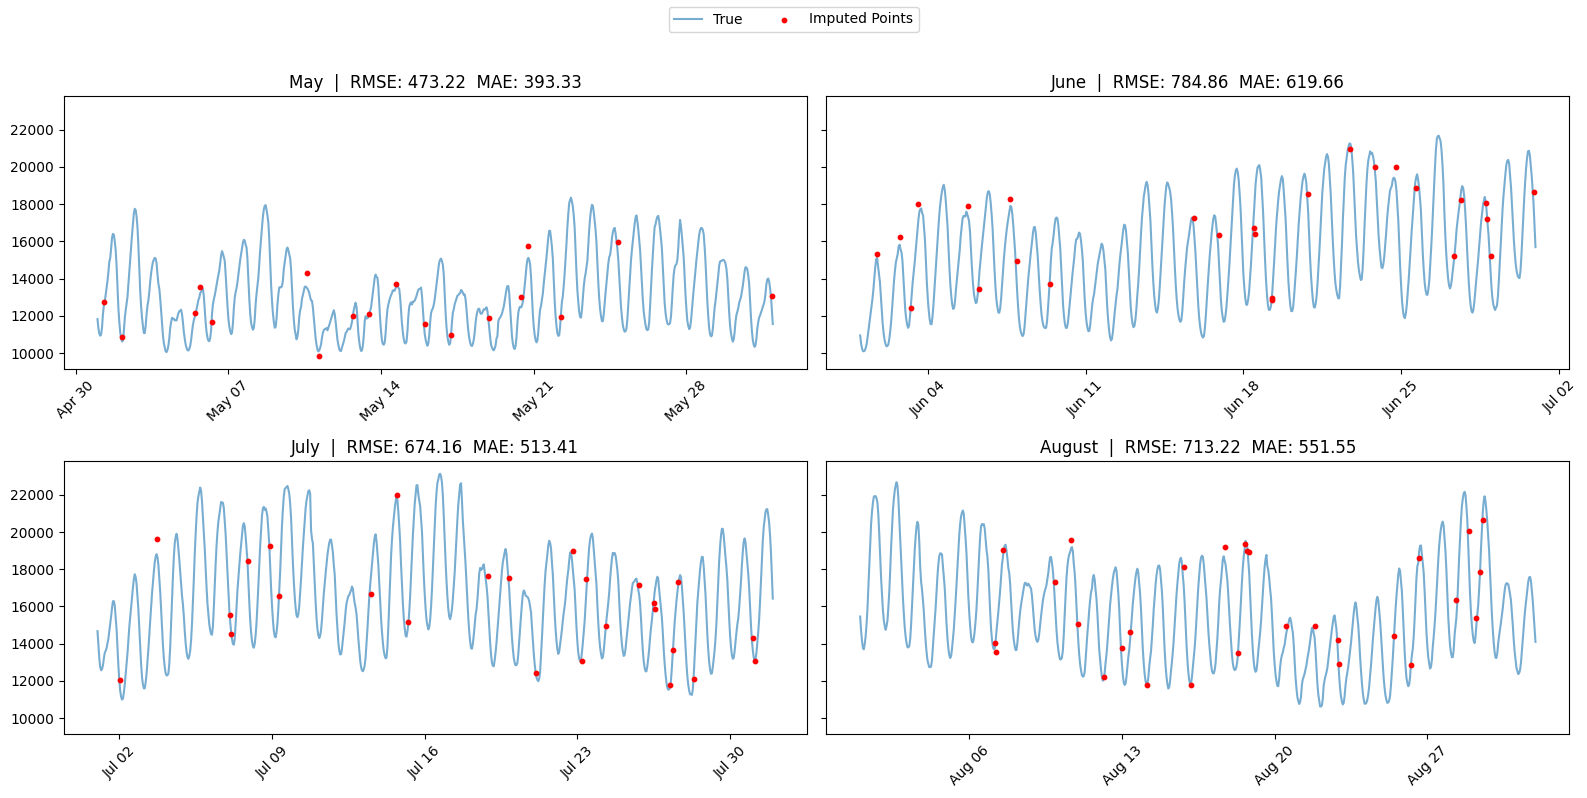

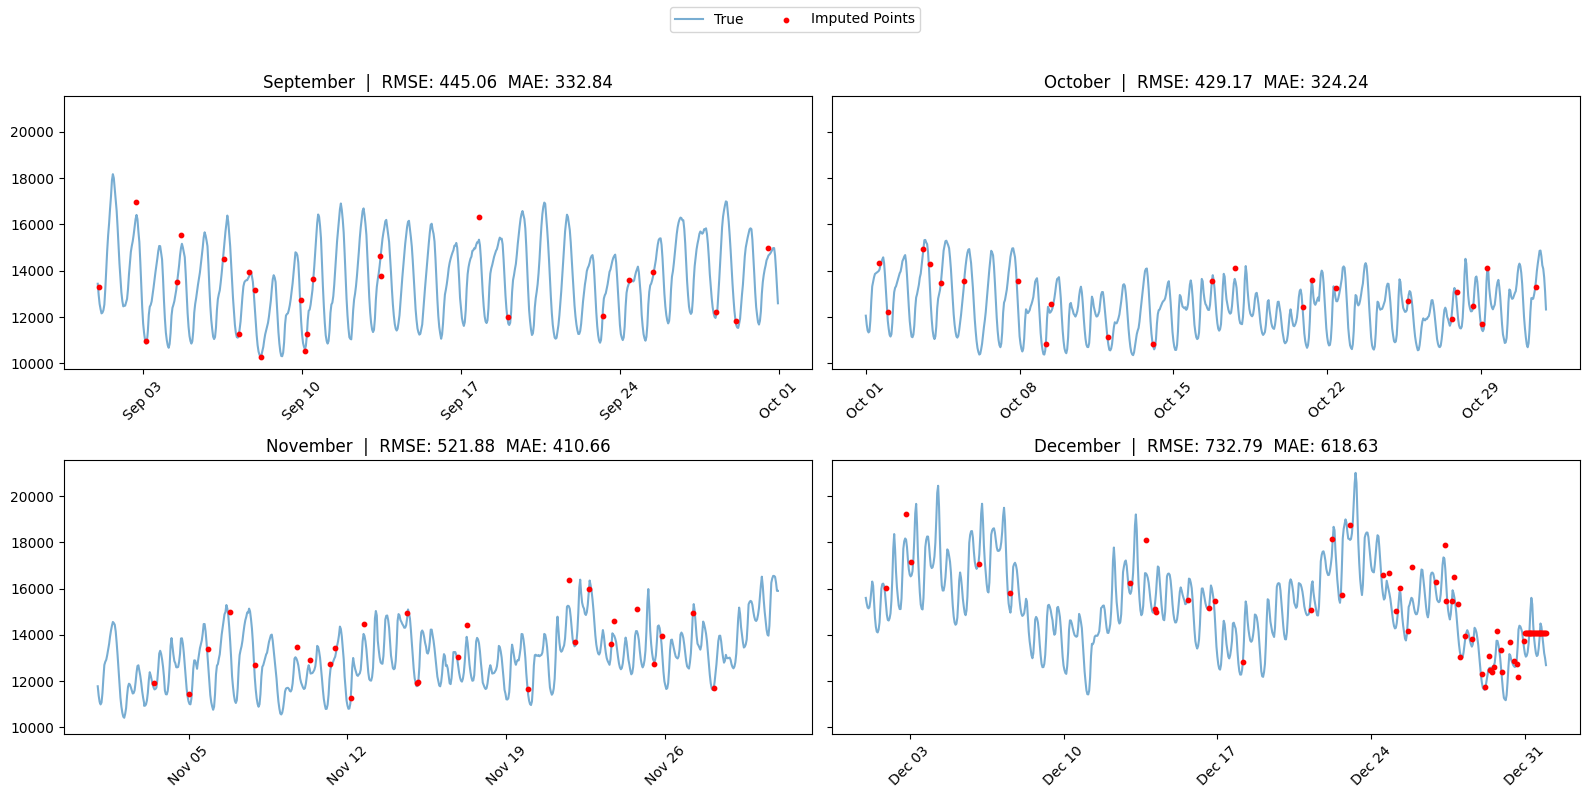

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Merge everything
pjm_2024 = df[df['year'] == 2024].reset_index(drop=True).copy()
pjm_2024['datetime'] = pd.to_datetime(pjm_2024[['year', 'month', 'day', 'hour']])
pjm_2024['true_mw'] = true_series
pjm_2024['imputed_mw'] = reconstructed
pjm_2024['mask'] = mask_all  # 1 = observed, 0 = missing

# Split months into 3 groups
month_groups = [
    [1, 2, 3, 4],     # Jan–Apr
    [5, 6, 7, 8],     # May–Aug
    [9, 10, 11, 12],  # Sep–Dec
]

for idx, group in enumerate(month_groups):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True)
    axes = axes.flatten()

    for i, month in enumerate(group):
        ax = axes[i]
        month_df = pjm_2024[pjm_2024['month'] == month]
        missing = month_df[month_df['mask'] == 0]

        # Calculate RMSE and MAE on missing values
        if not missing.empty:
            rmse = np.sqrt(np.mean((missing['true_mw'] - missing['imputed_mw'])**2))
            mae = np.mean(np.abs(missing['true_mw'] - missing['imputed_mw']))
        else:
            rmse = np.nan
            mae = np.nan

        # Plot true values
        ax.plot(month_df['datetime'], month_df['true_mw'], label='True', alpha=0.6)

        # Red dots at imputed locations
        ax.scatter(missing['datetime'], missing['imputed_mw'], color='red', s=10, label='Imputed Points', zorder=5)

        # Title with metrics
        month_name = pd.Timestamp(2024, month, 1).strftime('%B')
        ax.set_title(f"{month_name}  |  RMSE: {rmse:.2f}  MAE: {mae:.2f}")

        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(len(group), 4):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0, 1, 0.93])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)

    plt.show()
